In [1]:
import gluonts
gluonts.__version__

'0.4.2'

In [2]:
import mxnet
mxnet.__version__

'1.4.1'

In [4]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [6]:
dataname = "m4_yearly_demographic"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_yearly_demographic.


In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro', 'm4_yearly_other']


In [8]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [9]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='12M'),
 'target': array([ 3769.9,  3559. ,  3272.4,  2944.5,  3094. ,  3423.8,  3557.7,
         3859.9,  3970.1,  3832.2,  3963.3,  4143.7,  4578.5,  5021.9,
         5599.5,  5722.1,  5554.8,  4964.3,  4993.6,  5133.2,  5035.8,
         5242.4,  5641.5,  5770.2,  5891.8,  5738.7,  5908. ,  6084.5,
         6130.8,  5983.9,  6158.7,  6268. ,  6288.1,  6457.3,  6561.9,
         6727.5,  6969.2,  7351.6,  7544.2,  7760.2,  7985. ,  7975. ,
         7955.4,  8158.3,  8520.2,  8657.3,  8504.4,  8740.2,  9042.1,
         9477.7,  9801.7,  9837. ,  9922.5,  9730.5,  9804.1, 10245.8,
        10498.7, 10687.3, 10975.4, 11286.4, 11550.1, 11696.4, 11552.5,
        11596.8, 11760.4, 12037.9, 12323.6, 12546.1, 12831.6, 13156.3,
        13435. , 13722.8, 13689. , 13593.7, 13560.2, 13706.7, 13900.6,
        14144. , 14292.8, 14200. , 13617. ], dtype=float32),
 'feat_static_cat': array([1]),
 'source': SourceContext(source=Span(path=WindowsPath('C:/Us

## Plot Series

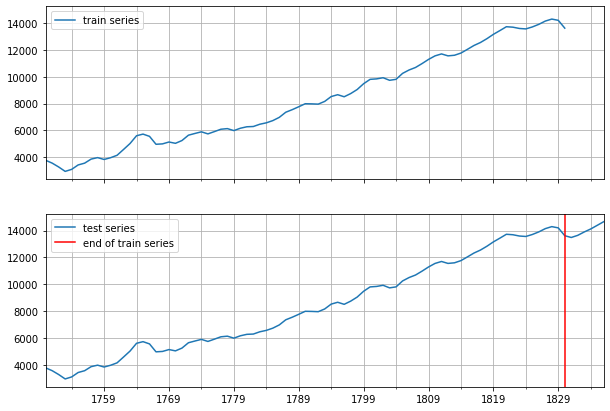

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator


### Monthly Subsets

In [15]:
%%time
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_monthly_micro", seed=i, epochs=343, batches=200)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:30<00:00,  6.57it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 30.446 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.346133
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:28<00:00,  7.01it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[1] Elapsed time 28.543 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.773222
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:28<00:00,  7.01it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[2] Elapsed time 28.523 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.266475
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:27<00:00,  7.36it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[3] Elapsed time 27.193 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=5.802288
INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 200/200 [00:35<00:00,  5.67it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[72] Elapsed time 35.290 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.931942
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 200/200 [00:29<00:00,  6.70it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[73] Elapsed time 29.870 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.277797
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 200/200 [00:31<00:00,  6.39it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[74] Elapsed time 31.324 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.511587
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 200/200 [00:34<00:00,  5.85it/s, avg_epoch_loss=6.6] 
INFO:root:Epoch[75] Elapsed time 34.176 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.596214
INFO:root:Epoch[76] Learning rate is 0.00025

100%|██████████| 200/200 [00:32<00:00,  6.14it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[143] Elapsed time 32.576 seconds
INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=5.777201
INFO:root:Epoch[144] Learning rate is 6.25e-05
 58%|█████▊    | 116/200 [00:30<00:21,  3.86it/s, avg_epoch_loss=5.76]


KeyboardInterrupt: 

In [16]:
%%time
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_monthly_micro", seed=i, epochs=172, batches=200)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:03<?, ?it/s, avg_epoch_loss=8.49]


KeyboardInterrupt: 

In [17]:
%%time
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_monthly_micro", seed=i, epochs=343, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt



### Yearly Subsets

In [18]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_finance", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_yearly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_macro", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_industry", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
# %%time
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly_micro", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results